In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib notebook

In [4]:
import sys
sys.path.append("../PyFalkon/src")
import time
import math

import numpy as np
import pandas as pd
import scipy
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import model_selection, preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from falkon import Falkon 
from nystrom import select_uniform_centers
from kernels import *
from utils import load_mat_data

## Data Load

In [5]:
fname = "./run_all.mat"
X, Y = load_mat_data(fname)

## Train/Test Split

In [6]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=37)

In [7]:
## Preprocessing
scaler = preprocessing.StandardScaler(copy=False, with_mean=True, with_std=True)
scaler.fit(X_train, Y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Y_train[Y_train == 0.0] = -1.0
Y_test[Y_test == 0.0] = -1.0

In [8]:
X.shape

(29545, 992)

## Run FALKON

In [15]:
## Parameters
M = 5000
sigma = 18
l = 1e-15
kernel = GaussianKernel(sigma)

In [16]:
## Nystrom - center selection
np.random.seed(34)
C = select_uniform_centers(X_train, M)

In [25]:
%%time
F = Falkon(kernel, l, maxiter=3, max_ram=1*2**30)
F.fit(X_train, C, Y_train)

Estimated doubles usage: 58400605.333333
3 blocks
...CPU times: user 2min 12s, sys: 14.6 s, total: 2min 27s
Wall time: 28 s


../PyFalkon/falkon.py:71: UserWarning: Conjugate gradient descent did not converge after 3 iterations!
  warnings.warn(f"Conjugate gradient descent did not converge after {info} iterations!")


## Timings (sigma 18, lambda 1e-10)


| time | M  | blocks | maxiter | notes |
|------ |----  |   |   |--          |
| 49.2s | 1000 | 5 | 5 | nopython=False |
| 47.7s | 1000 | 5 | 5 | nopython=True |
| 50.2s | 1000 | 5 | 5 | nopython=True, with jit signature |
| 49.8s | 1000 | 5 | 5 | nopython=True, with better cholesky |
| 51.4s | 1000 | 5 | 5 | nopython=True, inplace solve |
| 28.2s | 1000 | 5 | 5 | using better gaussian kernel computer (accum, gemm) |
| 28.7s | 1000 | 5 | 5 | using better gaussian kernel computer (ext, gemm) |
| 27.7s | 1000 | 5 | 5 | using better gaussian kernel computer (accum, dot) |
| 27.4s | 1000 | 5 | 5 | einsum kernel |
| 28.2s | 1000 | 1 | 5 | memory improvements + automatic block determination |


In [26]:
train_preds = np.sign(F.predict(X_train))
train_err = np.mean(train_preds != Y_train)
test_preds = np.sign(F.predict(X_test))
test_err = np.mean(test_preds != Y_test)

print(f"Train Error {train_err * 100:.2f}%")
print(f"Test Error {test_err * 100:.2f}%")

Estimated doubles usage: 58400605.333333
3 blocks
Estimated doubles usage: 62531818.000000
2 blocks
Train Error 14.96%
Test Error 21.10%


## Learning Curves

In [8]:
choice_M = [15000]
choice_lambda = [1e-5, 1e-4, 1e-3]#[1e-16, 1e-13, 1e-9, 1e-6]
choice_sigma = [1, 10, 100, 1000]

In [20]:
res_file = "/home/gmeanti/Desktop/unige/falkon/learning_res.csv"
#with open(res_file, "w") as fh:
#    fh.write("M,lambda,sigma,train-c-error,train-mse,test-c-error,test-mse,elapsed(s)\n")

for M in choice_M:
    for l in choice_lambda:
        for s in choice_sigma:
            np.random.seed(39)
            C = select_uniform_centers(X_train, M)
            kernel = GaussianKernel(s)
            
            start = time.time()
            print(f"Training with M={M}, sigma={s}, lambda={l}...")
            F = Falkon(kernel, l, maxiter=20)
            F.fit(X_train, C, Y_train)
            
            train_preds = np.sign(F.predict(X_train))
            train_c_err = np.mean(train_preds != Y_train)
            train_mse_err = np.mean((train_preds - Y_train)**2)
            
            test_preds = np.sign(F.predict(X_test))
            test_c_err = np.mean(test_preds != Y_test)
            test_mse_err = np.mean((test_preds - Y_test)**2)
            
            end = time.time()
            
            with open(res_file, "a") as fh:
                fh.write("%d,%.2E,%.2E,%.5f,%.5f,%.5f,%.5f,%.2f\n" % 
                         (M, l, s, train_c_err, train_mse_err, test_c_err, test_mse_err, end-start))


NameError: name 'choice_M' is not defined

## Learning Curve Plotting

In [70]:
df = pd.read_csv(res_file)
df.head()

,M,lambda,sigma,train-c-error,train-mse,test-c-error,test-mse,elapsed(s)
0,1000,1.000000e-16,1.0,0.38551,1.48811,0.40531,1.57607,9.13
1,1000,1.000000e-16,10.0,0.23934,0.95735,0.24759,0.99035,69.57
2,1000,1.000000e-16,100.0,0.18463,0.73853,0.21019,0.84075,71.34
3,1000,1.000000e-16,1000.0,0.18603,0.74412,0.20968,0.83872,70.35
4,1000,1.000000e-13,1.0,0.38551,1.48811,0.40531,1.57607,9.86


In [147]:
def plot_heatmap(df, xlabel, ylabel, colors, title=None, scale=None):
    fig, axs = plt.subplots(ncols=len(colors), figsize=(len(colors) * 5, 4.5))
    axs = np.ravel(axs)
    for i, color in enumerate(colors):
        piv = pd.pivot_table(df, index=ylabel, columns=xlabel, values=color)
        ax = axs[i]
        if scale is None:
            scale = (df[color].min(), df[color].max())
        cmap = cm.get_cmap('coolwarm_r', 20)
        c = ax.pcolormesh(piv, cmap=cmap, vmin=scale[0], vmax=scale[1])
        ax.set_yticks(np.arange(piv.shape[0]) + 0.5, minor=False)
        ax.set_xticks(np.arange(piv.shape[1]) + 0.5, minor=False)
        ax.set_xticklabels(piv.columns, minor=False)
        ax.set_yticklabels(piv.index, minor=False)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        cbar = fig.colorbar(c, ax=ax)
        cbar.set_label(color)
    
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    else:
        fig.tight_layout()
    return fig, axs

<IPython.core.display.Javascript object>


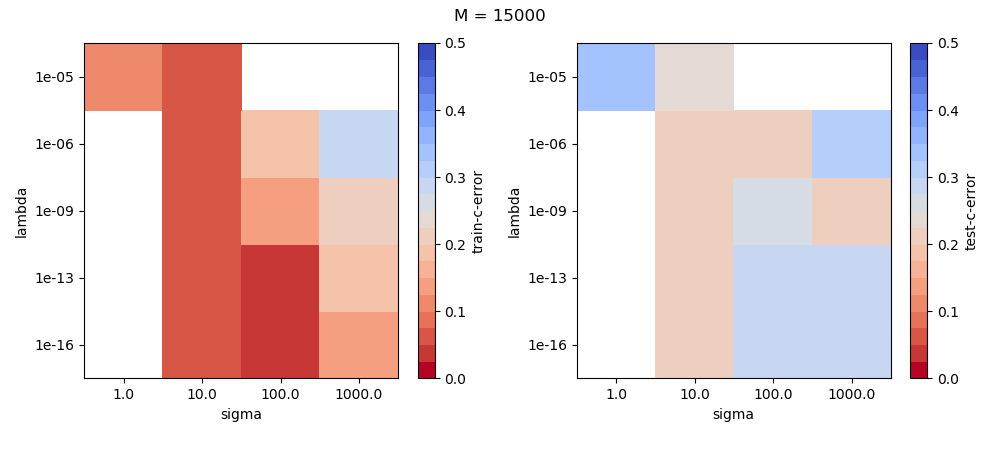

In [148]:
data = df[df["M"] == 15000]
fig, _ = plot_heatmap(data, "sigma", "lambda", 
                      ["train-c-error", "test-c-error"], 
                      scale=(0, 0.5), title="M = 15000")

<IPython.core.display.Javascript object>


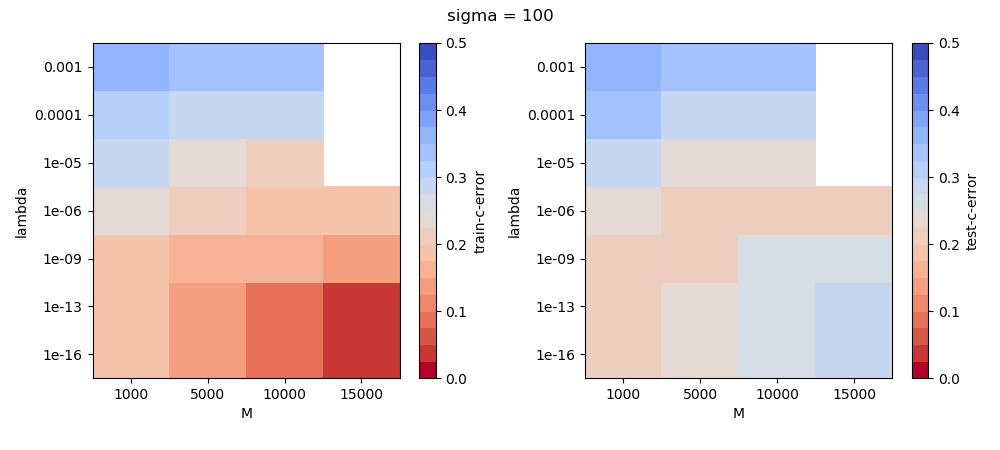

In [150]:
data = df[df["sigma"] == 100]
fig, _ = plot_heatmap(data, "M", "lambda", 
                      ["train-c-error", "test-c-error"],
                      scale=(0, 0.5), title="sigma = 100")

## Using Trained NN Weights

We train a simple neural net as specified below
```python
 nn.Sequential(
    nn.Linear(992, 7),
    nn.Sigmoid(),
    nn.Linear(7, 1))
```
which achieves 3,08% test error.

We extract the first layer weights of the trained NN (called `W0` below, of shape $7\times992$) and apply them to the original data as a dimensionality-reduction / feature extraction step.

We then train Falkon on the resulting data.
The results are heavily dependent on sigma, but with $\sigma = 1$ we find that we achieve results on par with the neural net (i.e. 3.42% test error).

In [9]:
weights = scipy.io.loadmat("nn_weights.mat")
W0 = weights["W0"]
W1 = weights["W1"]
print(W0.shape)
print(W1.shape)

(4, 992)
(1, 4)


In [45]:
X_train_nn = np.matmul(X_train, W0.T)
X_test_nn = np.matmul(X_test, W0.T)

In [8]:
## Parameters
M = 5000
sigma = 1
l = 1e-15
kernel = GaussianKernel(sigma)
np.random.seed(34)
C = select_uniform_centers(X_train_nn, M)

In [11]:
%%time
F = Falkon(kernel, l, maxiter=10, max_ram=1*2**30)
F.fit(X_train_nn, C, Y_train)

Estimated doubles usage: 58400605.333333
3 blocks
..........CPU times: user 2min 28s, sys: 41.7 s, total: 3min 10s
Wall time: 51.6 s


../PyFalkon/falkon.py:71: UserWarning: Conjugate gradient descent did not converge after 10 iterations!
  warnings.warn(f"Conjugate gradient descent did not converge after {info} iterations!")


In [12]:
train_preds = np.sign(F.predict(X_train_nn))
train_err = np.mean(train_preds != Y_train)
test_preds = np.sign(F.predict(X_test_nn))
test_err = np.mean(test_preds != Y_test)

print(f"Train Error {train_err * 100:.2f}%")
print(f"Test Error {test_err * 100:.2f}%")

Estimated doubles usage: 58400605.333333
3 blocks
Estimated doubles usage: 62531818.000000
2 blocks
Train Error 2.00%
Test Error 3.42%


## Dimensionality Reduction
 - PCA on NN-reduced data
 - tSNE on NN-reduced data

In [47]:
num_components = 2
dim_red = PCA(num_components, svd_solver="randomized", random_state=2937)
dim_red.fit(X_train_nn)

<IPython.core.display.Javascript object>


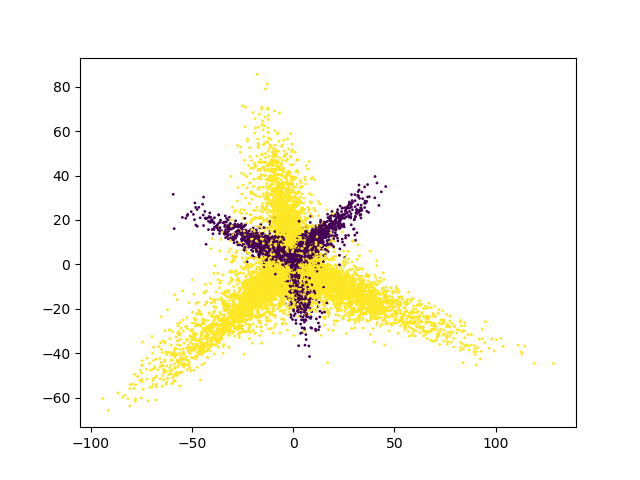

In [51]:
X_train_nn_pca = dim_red.transform(X_train_nn)
X_test_nn_pca = dim_red.transform(X_test_nn)

fig, ax = plt.subplots()
ax.scatter(X_train_nn_pca[:, 0], X_train_nn_pca[:, 1], c=Y_train, s=1)

In [65]:
tsne_red = TSNE(n_components=2, perplexity=40, early_exaggeration=14.0, learning_rate=150, n_iter=1000)
X_test_nn_tsne = tsne_red.fit_transform(X_test_nn)

<IPython.core.display.Javascript object>


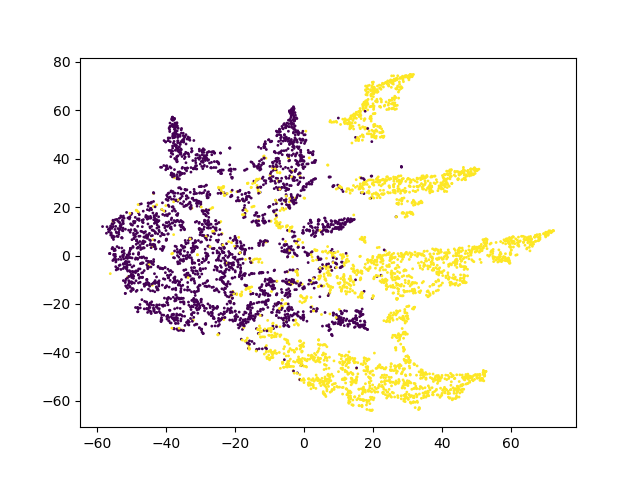

In [67]:
fig, ax = plt.subplots()
ax.scatter(X_test_nn_tsne[:, 0], X_test_nn_tsne[:, 1], c=Y_test, s=1)


In [71]:
del X_train_nn, X_test_nn, W0, W1, weights
del X_train_nn_pca, X_test_nn_pca
del X_test_nn_tsne

In [73]:
tsne_red = TSNE(n_components=2, perplexity=40, early_exaggeration=14.0, learning_rate=150, n_iter=1000)
X_test_tsne = tsne_red.fit_transform(X_test)

<IPython.core.display.Javascript object>


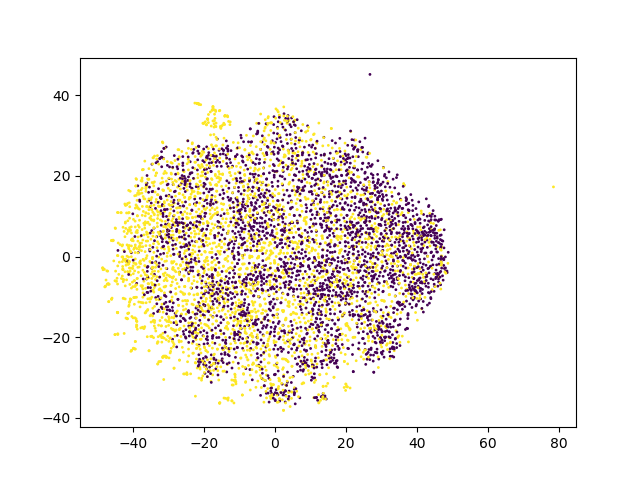

In [74]:
fig, ax = plt.subplots()
ax.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=Y_test, s=1)

## Use PCA transformed data
Check if PCA (linear transform) can find a better data representation...

Spoiler alert: it cannot (test error with M=5000: )

In [34]:
num_components = 7
dim_red = PCA(num_components, svd_solver="randomized", random_state=2937)

In [36]:
dim_red.fit(X_train)
X_train_pca = dim_red.transform(X_train)
X_test_pca = dim_red.transform(X_test)
print(X_train_pca.shape)

(23636, 7)


<IPython.core.display.Javascript object>


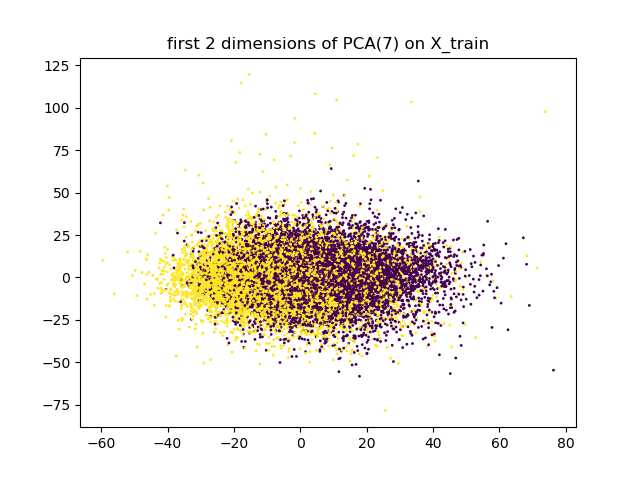

Text(0.5, 1.0, 'first 2 dimensions of PCA(7) on X_train')

In [37]:
fig, ax = plt.subplots()
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=Y_train, s=1)
ax.set_title("first 2 dimensions of PCA(7) on X_train")

In [28]:
## Parameters
M = 5000
sigma = 3
l = 1e-15
kernel = GaussianKernel(sigma)
np.random.seed(34)
C = select_uniform_centers(X_train_pca, M)

In [29]:
%%time
F = Falkon(kernel, l, maxiter=10, max_ram=1*2**30)
F.fit(X_train_pca, C, Y_train)

train_preds = np.sign(F.predict(X_train_pca))
train_err = np.mean(train_preds != Y_train)
test_preds = np.sign(F.predict(X_test_pca))
test_err = np.mean(test_preds != Y_test)

print(f"Train Error {train_err * 100:.2f}%")
print(f"Test Error {test_err * 100:.2f}%")

Estimated doubles usage: 58400605.333333
3 blocks
..........CPU times: user 1min 53s, sys: 27.7 s, total: 2min 20s
Wall time: 40.2 s


In [ ]:
del X_train_pca, X_test_pca

## Analyze (subsampled) data spectrum

In [43]:
cov = np.matmul(X_train[:5000], X_train[:5000].T)
w, v = np.linalg.eigh(cov)

<IPython.core.display.Javascript object>


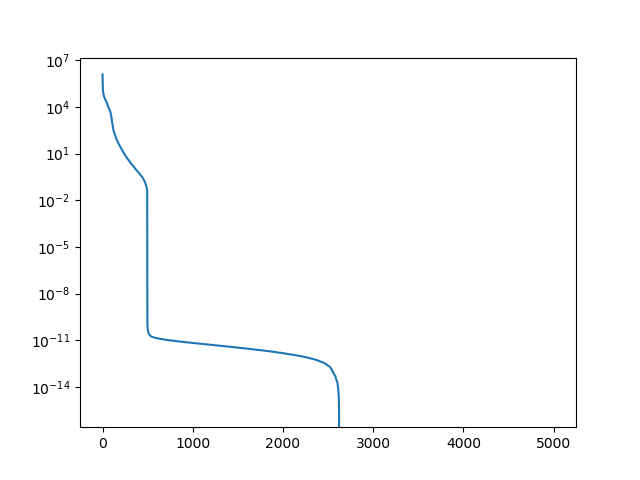

In [63]:
fig, ax = plt.subplots()
ax.plot(w[::-1])
ax.set_yscale("log")

In [65]:
kernel = GaussianKernel(sigma=18)
K = kernel(X_train[:5000])
wk, vk = np.linalg.eigh(K)

<IPython.core.display.Javascript object>


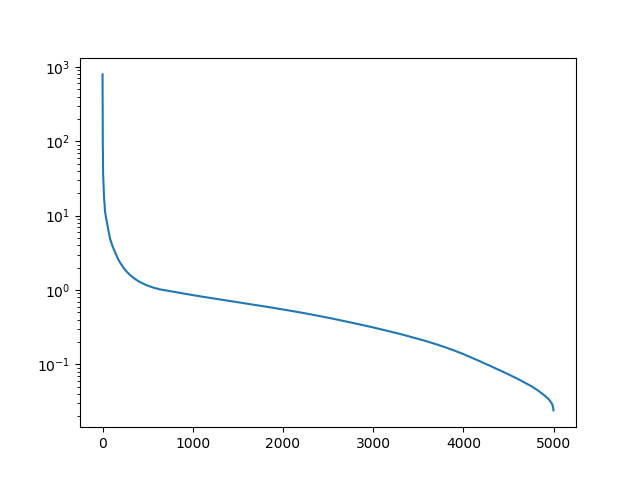

In [68]:
fig, ax = plt.subplots()
ax.plot(wk[::-1])
ax.set_yscale("log")

In [69]:
weights = scipy.io.loadmat("nn_weights.mat")
W0, W1 = weights["W0"], weights["W1"]
X_train_nn = np.matmul(X_train, W0.T)
cov_nn = np.matmul(X_train_nn[:5000], X_train_nn[:5000].T)
w_nn, v_nn = np.linalg.eigh(cov_nn)

<IPython.core.display.Javascript object>


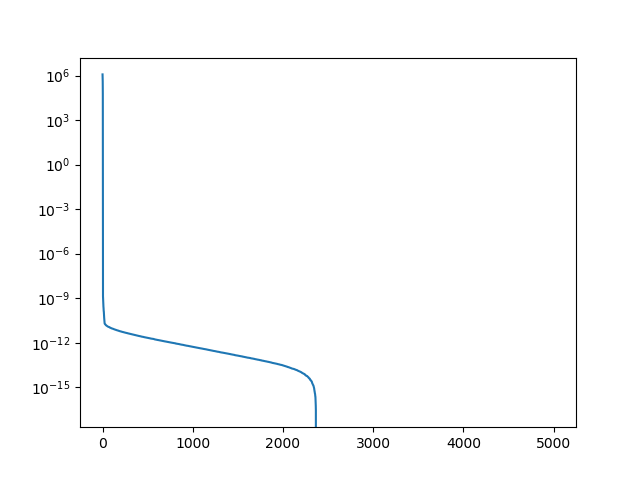

In [71]:
fig, ax = plt.subplots()
ax.plot(w_nn[::-1])
ax.set_yscale("log")

## NTK Tests

 - 3 ReLU layers (M=10k, l=1e-17): 
    * Train Error 9.05%
    * Test Error 20.82%
 - 2 ReLU layers
    * Train Error 8.67%
    * Test Error 20.98%

In [76]:
from jax.api import jit
from neural_tangents import stax

ModuleNotFoundError: No module named 'jax'

In [3]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(20), stax.Relu(),
    stax.Dense(20), stax.Relu(),
    stax.Dense(20), stax.Relu(),
    stax.Dense(20), stax.Relu(),
    stax.Dense(1),
)
kernel_fn = jit(kernel_fn)

In [75]:
## Parameters
M = 10000
l = 1e-17
kernel = JaxKernelWrapper("NTK", kernel_fn)
## Nystrom - center selection
np.random.seed(34)
C = select_uniform_centers(X_train, M)

NameError: name 'kernel_fn' is not defined

In [5]:
%%time
F = Falkon(kernel, l, maxiter=10, max_ram=1.5*2**30)
F.fit(X_train, C, Y_train)

NameError: name 'Falkon' is not defined

In [148]:
train_preds = np.sign(F.predict(X_train))
train_err = np.mean(train_preds != Y_train)
test_preds = np.sign(F.predict(X_test))
test_err = np.mean(test_preds != Y_test)

print(f"Train Error {train_err * 100:.2f}%")
print(f"Test Error {test_err * 100:.2f}%")

Estimated doubles usage: 216753938.666667
6 blocks
Estimated doubles usage: 233385151.333333
3 blocks
Dense layer
Dense layer
Dense layer
Dense layer
ReLU layer
Dense layer
Dense layer
Dense layer
Dense layer
ReLU layer
Dense layer
Dense layer
Dense layer
Dense layer
Dense layer
Dense layer
Dense layer
Dense layer
ReLU layer
Dense layer
Dense layer
Dense layer
Dense layer
ReLU layer
Dense layer
Dense layer
Dense layer
Dense layer
Train Error 8.67%
Test Error 20.98%


## Examine NN Centers
 - Plot of the centers, compared to random data-points
 - Comparison of the distances between data-centers and data-data. The distance matrices have a similar distribution.

In [8]:
weights = scipy.io.loadmat("nn_weights.mat")
W0 = weights["W0"]
W0.shape

<IPython.core.display.Javascript object>


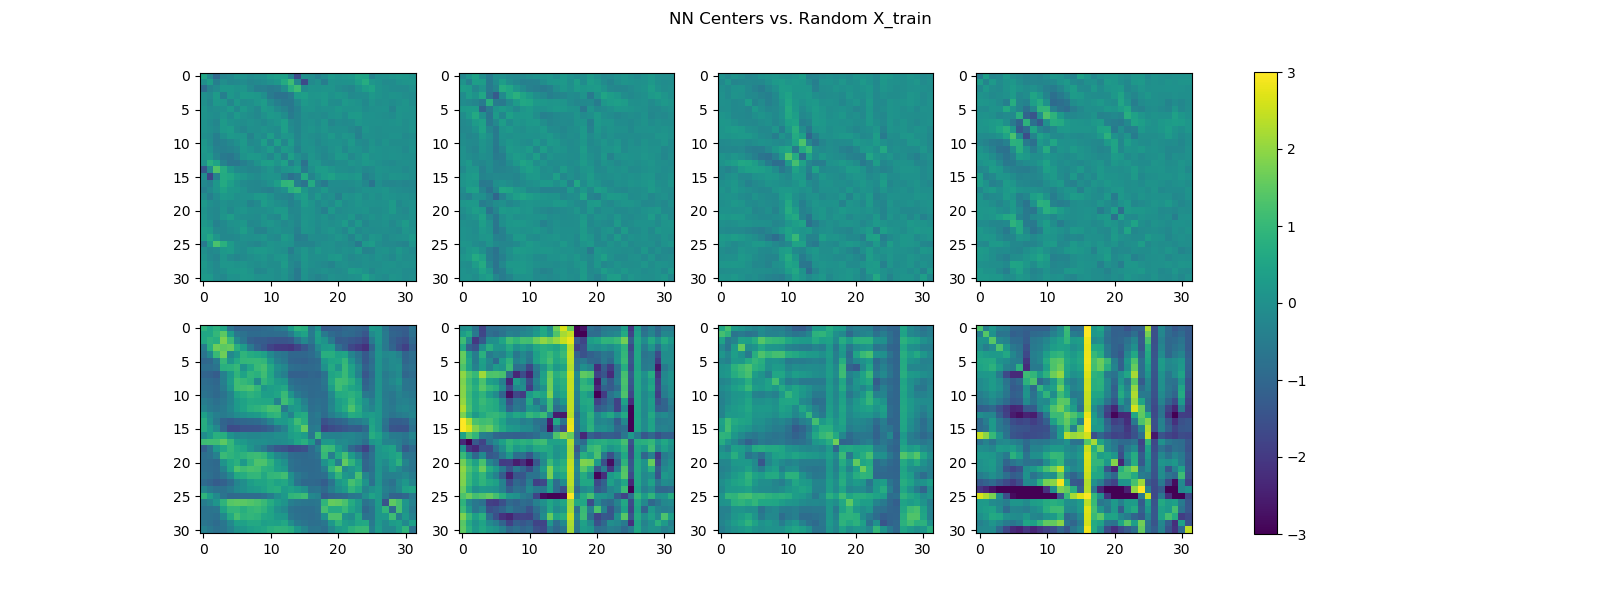

Text(0.5, 0.98, 'NN Centers vs. Random X_train')

In [42]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16, 6))
ax = ax.ravel()
vmin, vmax = -3, 3
im = ax[0].imshow(W0[0].reshape(31, 32), vmin=vmin, vmax=vmax)
im = ax[1].imshow(W0[1].reshape(31, 32), vmin=vmin, vmax=vmax)
im = ax[2].imshow(W0[2].reshape(31, 32), vmin=vmin, vmax=vmax)
im = ax[3].imshow(W0[3].reshape(31, 32), vmin=vmin, vmax=vmax)
im = ax[4].imshow(X_train[0].reshape(31, 32), vmin=vmin, vmax=vmax)
im = ax[5].imshow(X_train[1].reshape(31, 32), vmin=vmin, vmax=vmax)
im = ax[6].imshow(X_train[2].reshape(31, 32), vmin=vmin, vmax=vmax)
im = ax[7].imshow(X_train[3].reshape(31, 32), vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax.ravel().tolist())
fig.suptitle("NN Centers vs. Random X_train")

In [27]:
centers_dist = distance.cdist(W0, X_train, 'euclidean')

<IPython.core.display.Javascript object>


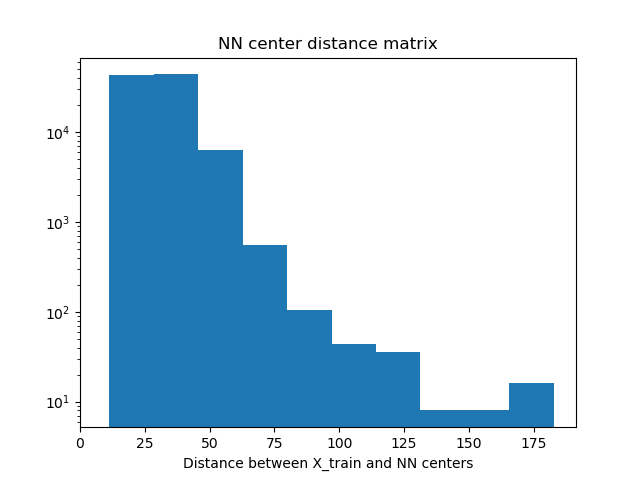

(0, 191.32731024488947)

In [44]:
fig, ax = plt.subplots()
ax.hist(centers_dist.ravel())
ax.set_yscale("log")
ax.set_xlabel("Distance between X_train and NN centers")
ax.set_title("NN center distance matrix")
ax.set_xlim([0, ax.get_xlim()[1]])

In [55]:
pctls = np.percentile(centers_dist.ravel(), [5, 25, 50, 75, 95], axis=0, overwrite_input=False)
print("Percentiles of the (nn-center--train-data) distance matrix: ")
print(pctls)
print()
print("Percentiles of the train-data distance matrix: ")
print([24.93945883, 33.66350065, 40.81442539, 49.41560314, 65.42663371])

Percentiles of the (nn-center--train-data) distance matrix: 
[16.93156193 23.32874207 29.42257044 36.24185588 48.59018444]

Percentiles of the train-data distance matrix: 
[24.93945883, 33.66350065, 40.81442539, 49.41560314, 65.42663371]


## Nearest neighbors
Find the top-K nearest neighbors between the NN centers and the training data.
Compare such distances with the distance between any nearest neighbors within the data.

This is done using the distance matrices.

# GridSearchCV Experiments

Contains two different experiments:
 - Kernel Ridge Regression
 - Support Vector Classification

In [21]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

In [22]:
def balanced_accuracy(y_true, y_pred):
    tp = np.sum(np.sign(y_pred[y_true == 1]) == 1)
    fn = np.sum(np.sign(y_pred[y_true == 1]) != 1)
    return tp / (tp + fn)  # recall

def f1_score(y_true, y_pred):
    tp = np.sum(np.sign(y_pred[y_true == 1]) == 1)
    fn = np.sum(np.sign(y_pred[y_true == 1]) != 1)
    fp = np.sum(np.sign(y_pred[y_true == -1]) != -1)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    return 2 * (precision * recall) / (precision + recall)

def accuracy(y_true, y_pred):
    return np.mean(np.sign(y_pred) == y_true)

In [23]:
def plot_cscv(res_df, x_col, y_col, c_col, ax=None, nstops=20, draw_cbar=True):
    if ax is None:
        fig, ax = plt.subplots()
        cmap = cm.get_cmap('coolwarm_r', nstops)
    
    piv = pd.pivot_table(res_df, 
                         index=y_col, columns=x_col,
                         values=c_col)
    c = ax.pcolormesh(piv, cmap=cmap, vmin=0.5, vmax=1.0)
    ax.set_yticks(np.arange(piv.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(piv.shape[1]) + 0.5, minor=False)
    ax.set_xticklabels(piv.columns, minor=False)
    ax.set_yticklabels(piv.index, minor=False)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(c_col)
    if draw_cbar:
        cbar = fig.colorbar(c, ax=ax)
    return fig, ax

In [24]:
Y[Y == 0.0] = -1
Y[Y == 1.0] = 1
Y = np.asarray(Y, dtype=np.int32)

In [25]:
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)

cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=3019)
scorers = {"f1": make_scorer(f1_score), 
           "accuracy": make_scorer(accuracy), 
           "balanced_accuracy": make_scorer(balanced_accuracy)}

## Full Kernel Ridge Regression Parameter Search

In [26]:
default_krr = KernelRidge(kernel="rbf")

pipeline = Pipeline(steps=[("rescale", scaler), ("krr", default_krr)])

param_search = [
#     {
#         "krr__kernel": ["rbf"], 
#         "krr__alpha": [1e-14, 1e-12, 1e-10, 1e-8, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
#         "krr__gamma": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
#     },
    {
        "krr__kernel": ["laplacian"],
        "krr__gamma": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    },
    {
        "krr__kernel": ["sigmoid"],
        "krr__gamma": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        "krr__coef0": [0, 1],
    },
    {
        "krr__kernel": ["polynomial"],
        "krr__degree": [2, 3, 4, 5, 6],
        "krr__gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
        "krr__coef0": [-1, 0, 1],
    }
]

krr_gs_cv = GridSearchCV(pipeline, param_search, scoring=scorers,
                     n_jobs=12, pre_dispatch=20, cv=cv_splitter, 
                     refit="accuracy", return_train_score=True, verbose=10,
                     error_score="raise")

In [27]:
krr_gs_cv.fit(X, Y)
krr_gs_cv

Fitting 5 folds for each of 127 candidates, totalling 635 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   5 tasks      | elapsed: 36.0min
[Parallel(n_jobs=12)]: Done  12 tasks      | elapsed: 36.3min
[Parallel(n_jobs=12)]: Done  21 tasks      | elapsed: 71.9min
[Parallel(n_jobs=12)]: Done  30 tasks      | elapsed: 106.0min
[Parallel(n_jobs=12)]: Done  41 tasks      | elapsed: 113.0min
[Parallel(n_jobs=12)]: Done  52 tasks      | elapsed: 152.3min
[Parallel(n_jobs=12)]: Done  65 tasks      | elapsed: 434.8min
[Parallel(n_jobs=12)]: Done  78 tasks      | elapsed: 487.5min
[Parallel(n_jobs=12)]: Done  93 tasks      | elapsed: 736.0min
[Parallel(n_jobs=12)]: Done 108 tasks      | elapsed: 972.8min
[Parallel(n_jobs=12)]: Done 125 tasks      | elapsed: 1289.3min
[Parallel(n_jobs=12)]: Done 142 tasks      | elapsed: 1698.2min
[Parallel(n_jobs=12)]: Done 161 tasks      | elapsed: 2095.5min
[Parallel(n_jobs=12)]: Done 180 tasks      | elapsed: 2375.4min


KeyboardInterrupt: 

In [19]:
try:
    krr_results = pd.DataFrame.from_records(krr_gs_cv.cv_results_)
except NameError:
    pass
    #krr_results = pd.read_csv("rbf_full_ictus_krr.csv", index_col=0)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [13]:
krr_results.sort_values(by="mean_test_accuracy", inplace=True, ascending=False)
krr_results.head()

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_f1,mean_train_accuracy,mean_train_balanced_accuracy,mean_train_f1,param_krr__alpha,param_krr__gamma,...,split4_train_balanced_accuracy,split4_train_f1,std_fit_time,std_score_time,std_test_accuracy,std_test_balanced_accuracy,std_test_f1,std_train_accuracy,std_train_balanced_accuracy,std_train_f1
74,114.884342,6.644675,0.800034,0.680844,0.770907,0.830149,0.719146,0.807129,0.00100,0.000010,...,0.721062,0.807982,3.226290,0.600160,0.003431,0.006955,0.004342,0.000852,0.001311,0.000997
106,111.260899,6.980116,0.799526,0.703377,0.776151,0.899907,0.830405,0.891304,1.00000,0.001000,...,0.829709,0.891577,3.816684,0.172277,0.003730,0.009112,0.005193,0.000934,0.001171,0.001021
95,113.469045,6.407217,0.799425,0.687146,0.771982,0.829870,0.724608,0.808050,0.10000,0.000100,...,0.725856,0.807890,2.830880,0.483561,0.003641,0.008465,0.005123,0.000374,0.000809,0.000263
53,116.091005,6.505942,0.799222,0.678584,0.769604,0.831689,0.721201,0.808983,0.00001,0.000001,...,0.723973,0.810505,2.401124,0.342928,0.003441,0.005917,0.004316,0.001141,0.002397,0.001512
64,113.298678,6.787803,0.794855,0.690227,0.768785,0.866526,0.779022,0.852261,0.00010,0.000010,...,0.780908,0.853706,2.011038,0.509655,0.005335,0.009839,0.006849,0.000705,0.001466,0.000867


In [14]:
##!! Save results to disk
krr_results.to_csv("./rbf_full_ictus_krr.csv")
##!! Save results to disk

<IPython.core.display.Javascript object>


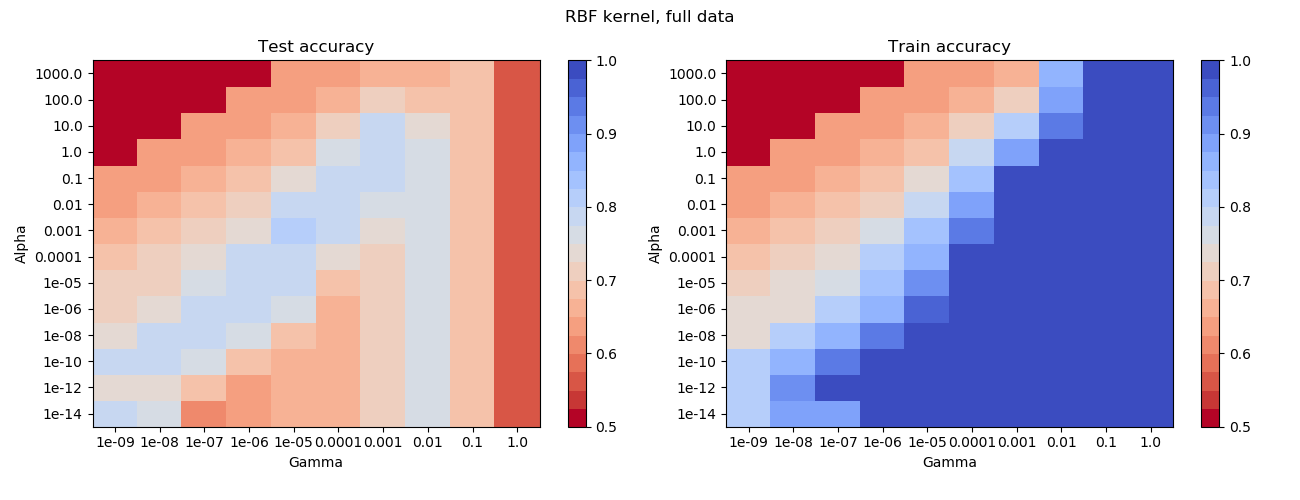

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(13, 5))

fig, ax = plot_cscv(results, "param_krr__gamma", "param_krr__alpha", "mean_test_accuracy", 
                    ax=axs[0])
ax.set_xlabel("Gamma")
ax.set_ylabel("Alpha")
ax.set_title("Test accuracy")

fig, ax = plot_cscv(results, "param_krr__gamma", "param_krr__alpha", "mean_train_accuracy", 
                    ax=axs[1])
ax.set_xlabel("Gamma")
ax.set_ylabel("Alpha")
ax.set_title("Train accuracy")

fig.suptitle("RBF kernel, full data")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("./rbf_full_ictus_krr.png")

<IPython.core.display.Javascript object>


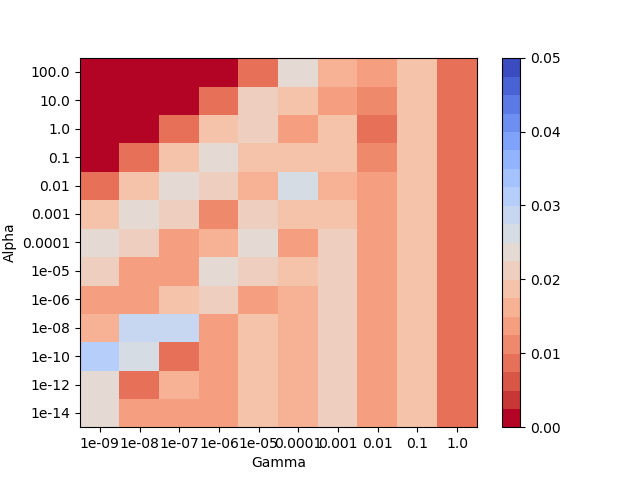

In [71]:
fig, ax = plot_cscv(results, "param_krr__gamma", "param_krr__alpha", "std_test_accuracy",
                    ax=None)
ax.set_xlabel("Gamma")
ax.set_ylabel("Alpha")
ax.set_title("Test Accuracy (std)")

## SVC

In [28]:
default_svc = SVC(kernel="rbf")

pipeline = Pipeline(steps=[("rescale", scaler), ("svc", default_svc)])

param_search = {
    "svc__C": [1e-3, 1e-2, 1, 100, 500],
}
svc_gs_cv = GridSearchCV(pipeline, param_search, scoring=scorers,
                         n_jobs=4, pre_dispatch=8, cv=cv_splitter, 
                         refit="accuracy", return_train_score=True, verbose=10,
                         error_score="raise")

In [ ]:
svc_gs_cv.fit(X, Y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 59.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 89.0min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 144.8min


In [17]:
try:
    svc_results = pd.DataFrame.from_records(svc_gs_cv.cv_results_)
except NameError:
    pass
    #svc_results = pd.read_csv("rbf_full_ictus_svc.csv", index_col=0)

In [32]:
svc_results.sort_values(by="mean_test_accuracy", inplace=True, ascending=False)
svc_results.head()

,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_f1,mean_train_accuracy,mean_train_balanced_accuracy,mean_train_f1,param_svc__C,params,...,split4_train_balanced_accuracy,split4_train_f1,std_fit_time,std_score_time,std_test_accuracy,std_test_balanced_accuracy,std_test_f1,std_train_accuracy,std_train_balanced_accuracy,std_train_f1
4,741.543006,117.429003,0.803249,0.687624,0.775486,0.866559,0.772293,0.851198,1,{'svc__C': 1},...,0.773202,0.851941,25.794213,3.821593,0.003240,0.006741,0.004212,0.000525,0.001448,0.000722
5,5651.832383,98.151418,0.800305,0.776385,0.793494,0.999154,0.998305,0.999143,100,{'svc__C': 100},...,0.998373,0.999186,244.584470,5.022785,0.002595,0.005995,0.003268,0.000128,0.000273,0.000130
3,791.509913,166.248247,0.678626,0.704678,0.684271,0.681274,0.707161,0.686810,0.01,{'svc__C': 0.01},...,0.710103,0.688413,26.408222,4.201076,0.003453,0.004077,0.002772,0.000613,0.001618,0.000848
0,825.616516,190.822295,0.505805,0.000000,NaN,0.505805,0.000000,NaN,1e-08,{'svc__C': 1e-08},...,0.000000,NaN,9.704656,2.821187,0.000068,0.000000,NaN,0.000017,0.000000,NaN
1,847.020683,206.414799,0.505805,0.000000,NaN,0.505805,0.000000,NaN,1e-06,{'svc__C': 1e-06},...,0.000000,NaN,17.631248,19.182647,0.000068,0.000000,NaN,0.000017,0.000000,NaN


<IPython.core.display.Javascript object>


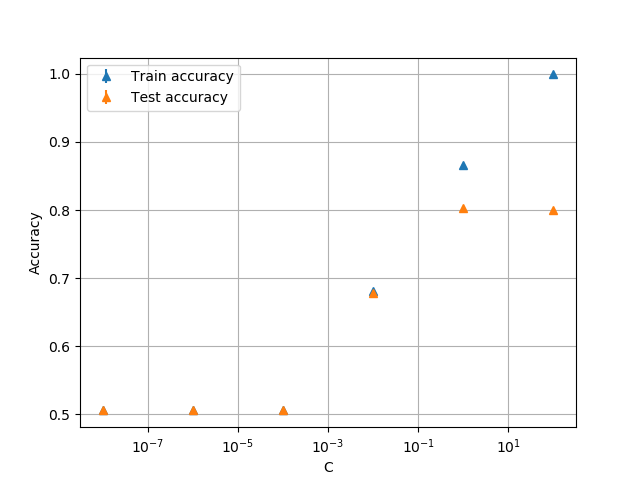

In [42]:
fig, ax = plt.subplots()
svc_results.sort_values(by="param_svc__C", inplace=True, ascending=False)
ax.errorbar(svc_results["param_svc__C"], svc_results["mean_train_accuracy"], svc_results["std_train_accuracy"],
            label="Train accuracy", linestyle='None', marker='^')
ax.errorbar(svc_results["param_svc__C"], svc_results["mean_test_accuracy"], svc_results["std_test_accuracy"],
           label="Test accuracy", linestyle='None', marker='^')
ax.set_xlabel("C")
ax.set_ylabel("Accuracy")
ax.set_xscale("log")
ax.legend(loc="best")
ax.grid()
#fig.savefig("./rbf_full_ictus_svc.png")

## Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=25, max_samples=0.7, criterion="entropy")
rfc.fit(X_train, Y_train)
print("Train accuracy: %.4f" % (rfc.score(X_train, Y_train)))
print("Test accuracy: %.4f" % (rfc.score(X_test, Y_test)))

Train accuracy: 1.0000
Test accuracy: 0.7697


## AdaBoost
 - n_estimators 150, lr 0.3, d 1: 0.75, 0.73

In [88]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [95]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                         n_estimators=150,
                         learning_rate=1.2)
abc.fit(X_train, Y_train)
print("Train accuracy: %.4f" % (abc.score(X_train, Y_train)))
print("Test accuracy: %.4f" % (abc.score(X_test, Y_test)))

Train accuracy: 0.7779
Test accuracy: 0.7394


In [96]:
## DD

In [122]:
from nystrom_sgd import NystromSGD

In [129]:
## Parameters
M = 500
sigma = 18
lr = 0.001
kernel = GaussianKernel(sigma)
## Nystrom - center selection
np.random.seed(35)
C = select_uniform_centers(X_train, M)

nsgd = NystromSGD(kernel, lr, 100)

In [130]:
nsgd.fit(X_train, C, Y_train)

Epoch 0 - Accuracy 0.600
Epoch 1 - Accuracy 0.605
Epoch 2 - Accuracy 0.607
Epoch 3 - Accuracy 0.609
Epoch 4 - Accuracy 0.610
Epoch 5 - Accuracy 0.611
Epoch 6 - Accuracy 0.612
Epoch 7 - Accuracy 0.613
Epoch 8 - Accuracy 0.613
Epoch 9 - Accuracy 0.614
Epoch 10 - Accuracy 0.614
Epoch 11 - Accuracy 0.614
Epoch 12 - Accuracy 0.615
Epoch 13 - Accuracy 0.616
Epoch 14 - Accuracy 0.616
Epoch 15 - Accuracy 0.616
Epoch 16 - Accuracy 0.616
Epoch 17 - Accuracy 0.617
Epoch 18 - Accuracy 0.617
Epoch 19 - Accuracy 0.617
Epoch 20 - Accuracy 0.617
Epoch 21 - Accuracy 0.618
Epoch 22 - Accuracy 0.618
Epoch 23 - Accuracy 0.618
Epoch 24 - Accuracy 0.618
Epoch 25 - Accuracy 0.618
Epoch 26 - Accuracy 0.618
Epoch 27 - Accuracy 0.618
Epoch 28 - Accuracy 0.618
Epoch 29 - Accuracy 0.618
Epoch 30 - Accuracy 0.618
Epoch 31 - Accuracy 0.618
Epoch 32 - Accuracy 0.619
Epoch 33 - Accuracy 0.619
Epoch 34 - Accuracy 0.619
Epoch 35 - Accuracy 0.619
Epoch 36 - Accuracy 0.619
Epoch 37 - Accuracy 0.619
Epoch 38 - Accuracy 0.